# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

## **Problem Approach**

### **Importing Base Libraries**

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import time

In [3]:
# Downloading necessary packages for nlp
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PorterStemmer, SnowballStemmer
import string, re, ast

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### **Data Exploration**

In [8]:
df = pd.read_csv('/gdrive/MyDrive/Data Science - Almabetter/Capstone Project/Coronavirus Tweet Sentiment Analysis/Coronavirus Tweets.csv', encoding='latin-1')

In [9]:
df.shape

(41157, 6)

In [10]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
df.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [13]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

So we've 8590 null values for only location out of 41157 i.e. over 20%. Also we don't think in a cloud social media platform like twitter, a topic like covid-19 which is actually a global crisis, location would affect that much

### **Basic Text Preprocessing**

Processing Text in NLP is traditionally the elemental step. The steps will be consider is

1.   Lower case the texts
2.   Any url links (ex. http:, https: ) are to be replaced by word `url`
3.   Any mentioned user in twitter starting by @ are to be replaced by word `user`
4.   Any non-alphabet characters
5.   3 or more consecutive letter to be replaced by 2 letter
6.   Any word with a length of less than 3
7.   Remove all english stopwords

In [19]:
filtered_df = df.copy()

In [20]:
def remove_stopwords(text: list) -> list:
    sw = stopwords.words('english')
    return [word.lower() for word in text if word.lower() not in sw]

In [21]:
def process_text(text: str, min_length: int = 3, rmv_sw: bool = True) -> str:
    # removing mentioned user in twitter
    text = re.sub(r'@[\w]*', 'user', text.lower())
    # remove any sort of url
    text = re.sub(r'http\S+', 'url', text)
    # remove anything except a-z
    text = re.sub(r'[^a-z ]', '', text)
    # replace 3 or more consecutive letters with 2 letters
    text = re.sub(r'(.)\1\1+', r'\1\1', text)
    # remove any word having a length of less than min_length
    text = [word for word in word_tokenize(text) if len(word) >= min_length]

    # whether to remove stopwords or not
    if rmv_sw:
        text = remove_stopwords(text)

    return " ".join(text)

filtered_df['processed_tweet'] = filtered_df['OriginalTweet'].apply(process_text)

### **Exploratory Data Analysis**

In [14]:
def flatten(lists_of_list: list) -> list:
    return [item for sublist in lists_of_list for item in sublist]

In [15]:
def extract_hashtags(tweet_lists: list) -> list:
    hashtags = []
    for tweet in tweet_lists:
        ht = re.findall(r"#(\w+)", tweet)
        if (len(ht) > 0):
            hashtags.append(ht)

    return flatten(hashtags)

In [ ]:
from collections import Counter
from wordcloud import WordCloud

hashtags_count = Counter(extract_hashtags(df['OriginalTweet']))

print("Most 20 frequent hashtags used are :")
pd.DataFrame(hashtags_count.most_common(20), columns=['hastags', 'count'])

Most 20 frequent hashtags used are :


,hastags,count
0,coronavirus,12954
1,COVID19,3364
2,Covid_19,2589
3,Coronavirus,2333
4,COVID2019,1634
5,toiletpaper,1410
6,COVID,1284
7,covid19,1127
8,CoronaCrisis,734
9,CoronaVirus,645


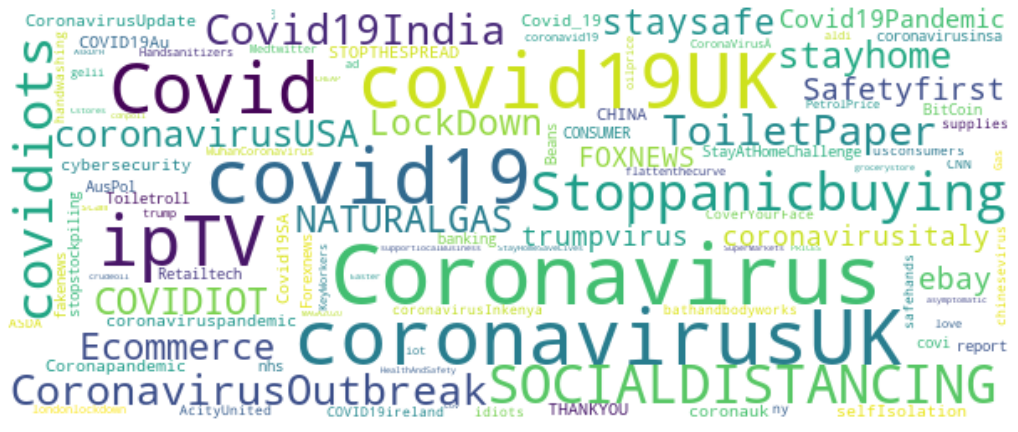

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, height=250, width=600, background_color="white", normalize_plurals=False).generate(" ".join(set(extract_hashtags(df['OriginalTweet']))))
plt.figure(figsize=(18, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Hummm, such a worldwide pandemic & *`#ToiletPaper`* was on the trending !!! ✌

In [ ]:
filtered_df['processed_tweet'] = filtered_df['processed_tweet'].replace('', np.nan)
filtered_df = filtered_df.dropna(subset=['processed_tweet'])

In [ ]:
filtered_df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7712
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

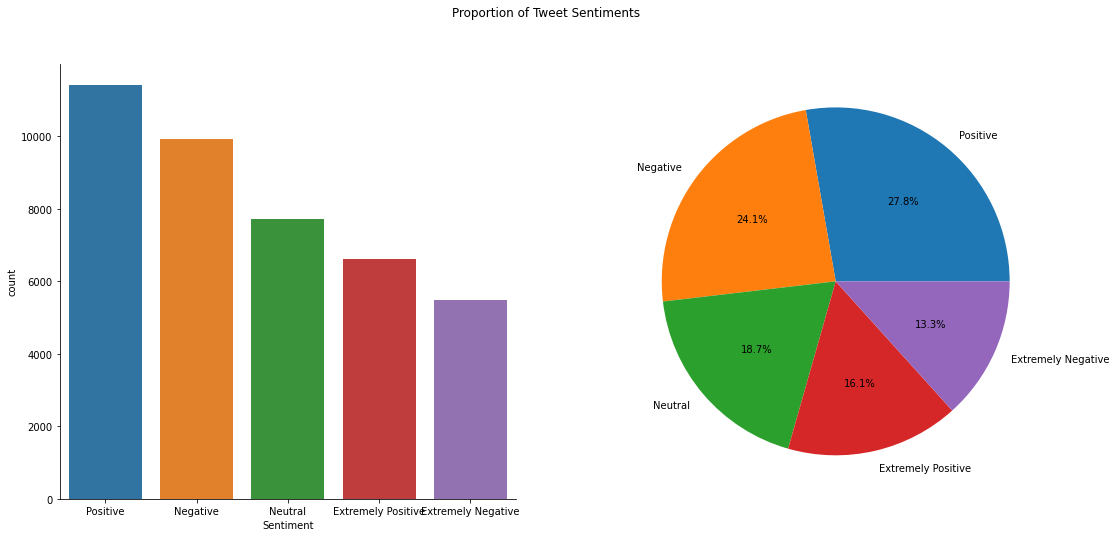

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
ax = axes.flatten()
sns.countplot(data=filtered_df, x='Sentiment', order=filtered_df['Sentiment'].value_counts().index, ax=ax[0])

labels = filtered_df['Sentiment'].value_counts().index
sizes = filtered_df['Sentiment'].value_counts().values
ax[1].pie(sizes, labels=labels, autopct='%1.1f%%')

plt.suptitle("Proportion of Tweet Sentiments")
sns.despine()

We can check Positive tweets count is highest with 11422 samples. 
\
The ratio of target labels are 1.20853859, 2.08392629, 1.40722496, 1.80934136, 1 respectively for Pos, Neg, Neu, ExPos, ExNeg

In [39]:
filtered_df['TweetAt'] = pd.to_datetime(filtered_df['TweetAt'])

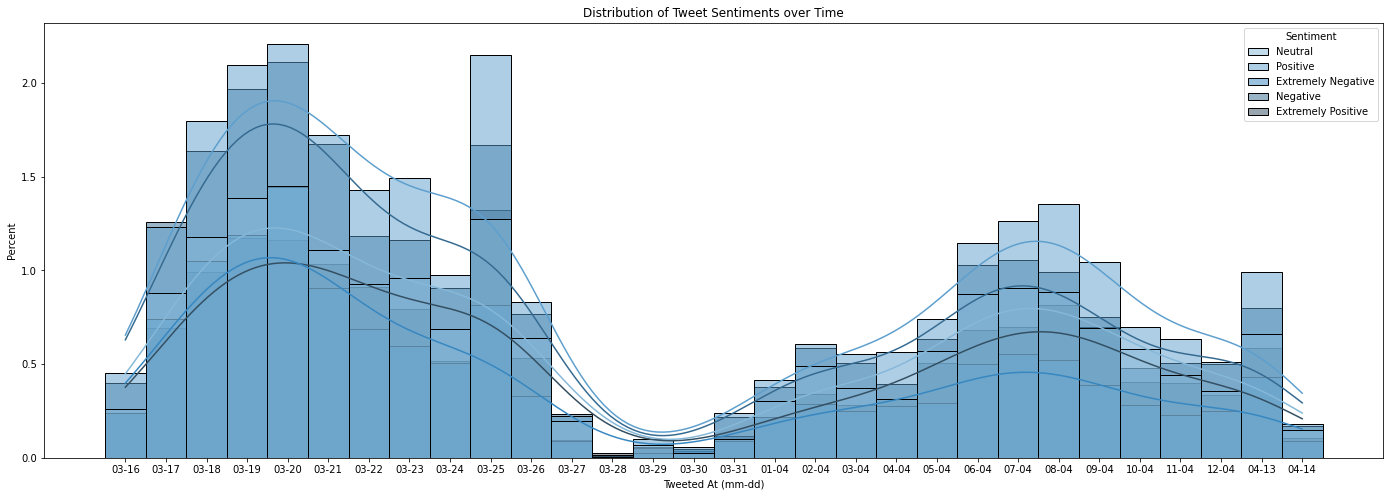

In [45]:
pd.options.mode.chained_assignment = None

filtered_df['TweetAt_m-d'] = filtered_df['TweetAt'].dt.strftime('%m-%d')

plt.figure(figsize=(24, 8))
ax = sns.histplot(data=filtered_df, x='TweetAt_m-d', hue='Sentiment', stat='percent', kde=True, palette="Blues_d")
ax.set_xlabel('Tweeted At (mm-dd)')
plt.title('Distribution of Tweet Sentiments over Time')
plt.show()

In [34]:
filtered_df['OriginalTweet_len'] = filtered_df['OriginalTweet'].str.split().str.len()
filtered_df['url_len'] = filtered_df['processed_tweet'].str.count('url')

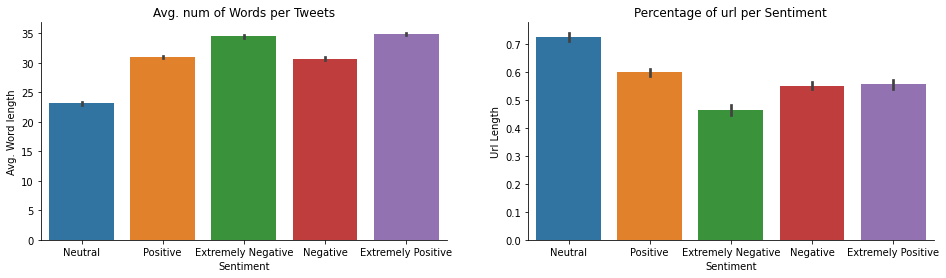

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
ax = axes.flatten()
sns.barplot(data=filtered_df, x='Sentiment', y='OriginalTweet_len', ax=ax[0])
ax[0].set_title('Avg. num of Words per Tweets')
ax[0].set_ylabel('Avg. Word length')
sns.barplot(data=filtered_df, x='Sentiment', y='url_len', ax=ax[1])
ax[1].set_title('Percentage of url per Sentiment')
ax[1].set_ylabel('Url Length')
sns.despine()

In [ ]:
# to avoid SettingWithCopyWarning
pd.options.mode.chained_assignment = None

filtered_df['word_list'] = filtered_df.loc[:, 'processed_tweet'].apply(word_tokenize)
top = Counter([item for sublist in filtered_df.loc[:, 'word_list'] for item in sublist])
all_common_df = pd.DataFrame(top.most_common(10000))
all_common_df.columns = ['Common Word', 'Count']

print(f"Total unique words : {all_common_df.shape[0]}")
all_common_df.head()

Total unique words : 10000


,Common Word,Count
0,url,20324
1,covid,20270
2,user,16677
3,coronavirus,16415
4,prices,7646


In [ ]:
filtered_df['Sentiment_label'] = filtered_df['Sentiment'] \
    .replace({"Extremely Negative" : 0, "Negative" : 1, "Neutral": 2, "Positive" : 3, "Extremely Positive": 4})

In [ ]:
# filtering only negative and extreme negative
top = Counter([item for sublist in filtered_df.loc[filtered_df['Sentiment_label'].isin([0, 1]), 'word_list'] for item in sublist])
negative_common_df = pd.DataFrame(top.most_common(10000))
negative_common_df.columns = ['Common Word', 'Count']

In [ ]:
# filtering only positive and extreme positive
top = Counter([item for sublist in filtered_df.loc[filtered_df['Sentiment_label'].isin([3, 4]), 'word_list'] for item in sublist])
positive_common_df = pd.DataFrame(top.most_common(10000))
positive_common_df.columns = ['Common Word', 'Count']

In [ ]:
# filtering neutral tweets only
top = Counter([item for sublist in filtered_df.loc[filtered_df['Sentiment_label'].isin([2]), 'word_list'] for item in sublist])
neutral_common_df = pd.DataFrame(top.most_common(10000))
neutral_common_df.columns = ['Common Word', 'Count']

In [ ]:
fig = px.treemap(all_common_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Common Words')
fig.show()

In [ ]:
fig = px.treemap(negative_common_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Common Negative Words')
fig.show()

In [ ]:
fig = px.treemap(positive_common_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Common Positive Words')
fig.show()

Now, we'll calculate unique words for each classes (Po, Ne & Neu) i.e. words that have appeared only in a particular label. \
To calculate this,


*   We will create a list of all words in dataset
*   We will filter words that are not in our required labels
*   We will use set operation to filter out words only in label

In [ ]:
all_words_list = [word for word_list in filtered_df['word_list'] for word in word_list]

In [ ]:
def words_unique(sentiment_lbl_list: list, to_be_filtered_from_df):
    '''
    Input:
        sentiment_lbl_list - list of sentiment labels ex. [0, 1] for only unique negative words;
        to_be_filtered_from_df - previously created dataframe with most common words, ex. to filter
                                negative words, negative words dataframe is required to be passed;
    Output: 
        dataframe with only unique words particular in the passed sentiment labels 

    '''
    # specific words not part of given labels
    notinlbl_words_list = flatten(filtered_df.loc[~filtered_df['Sentiment_label'].isin(sentiment_lbl_list)]['word_list'])
    # little bit of set theory here
    # intersecting all words with not in labels words, gives us only in labels word
    filtered_lbl_lists = list(set(all_words_list) - set(notinlbl_words_list))

    # just to return a dataframe for plotting with count
    return to_be_filtered_from_df.loc[to_be_filtered_from_df['Common Word'].isin(filtered_lbl_lists)]

In [ ]:
only_positive_df = words_unique([3, 4], positive_common_df)

fig = px.treemap(only_positive_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Occured Unique Positive Words')
fig.show()

In [ ]:
only_negative_df = words_unique([0, 1], negative_common_df)

fig = px.treemap(only_negative_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Occured Unique Negative Words')
fig.show()

In [ ]:
only_neutral_df = words_unique([2], neutral_common_df)

fig = px.treemap(only_neutral_df.head(200), path=['Common Word'], values='Count',title='Top 200 Most Occured Unique Neutral Words')
fig.show()

### **Text Normalization**

We'll do lemmatization as part of text normalization, which is used to keep only the base of a word with the help of vocabulary & parts-of-speech.

> *(edit)* We're going to skip lemmatization but to use stemming because we're getting less features (or less dimensions) with stemming, it slightly affecting our accuracy score and also computational power. But overall, the results are more or less same.



In [ ]:
def lemmatize_word(text: str) -> str:
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))

    return " ".join(lemmatized_sentence)

We'll use `SnowballStemmer` to perform stemming, it is a better version of the traditional `PorterStemmer` . Stemming removes prefix, suffix and affixes thus results in reduced dimensionality

In [ ]:
def stem_word(text: str) -> str:
    porter = SnowballStemmer('english')
    stemmed_words = []
    for txt in word_tokenize(text):
        stemmed_words.append(porter.stem(txt))

    return " ".join(stemmed_words)

In [ ]:
# filtered_df['tokenized_tweet'] = filtered_df['processed_tweet'].apply(lemmatize_word)
# we'll be using only stemming for reduced dimensionality
filtered_df['tokenized_tweet'] = filtered_df['processed_tweet'].apply(stem_word)

In [ ]:
filtered_df[['OriginalTweet', 'processed_tweet', 'tokenized_tweet']].sample(10)

,OriginalTweet,processed_tweet,tokenized_tweet
9349,Ok so I m now in the front room psyching mysel...,front room psyching supermarket trying fuck ap...,front room psych supermarket tri fuck approach...
15081,May we present Britain s no 2 the popular su...,may present britain popular supermarket create...,may present britain popular supermarket creat ...
8298,Here are the 4 most important things to know a...,important things know governments minimum payo...,import thing know govern minimum payout americ...
31165,Join #grocery experts from @Sendiks and @fresh...,join grocery experts user user share best prac...,join groceri expert user user share best pract...
9152,My local corner shop is open and the shelves f...,local corner shop open shelves full prices rec...,local corner shop open shelv full price recomm...
21713,"""[M]ore than 37 million people struggle with h...",million people struggle hunger food banks acro...,million peopl struggl hunger food bank across ...
24288,With #coronavirus hitting pet food availabilit...,coronavirus hitting pet food availability stoc...,coronavirus hit pet food avail stock user cat ...
35014,@fordnation @WHO @CPHO_Canada GROCERY SHOPPIN...,user user user grocery shopping suggestion gro...,user user user groceri shop suggest groceri st...
31943,Grocery store employees in U.S are starting to...,grocery store employees starting die coronavir...,groceri store employe start die coronavirus url
1094,Electricity demand and high amounts of wind po...,electricity demand high amounts wind power red...,electr demand high amount wind power reduc pri...


### **Model Preparation**

we will train test split the data 0.2 test ratio and use pipeline to train & evaluate model performance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df['tokenized_tweet'], filtered_df['Sentiment'], test_size=0.2, \
                                                    stratify=filtered_df['Sentiment'], random_state=10)

In [ ]:
X_train.shape, X_test.shape

((32924,), (8232,))

#### **Defining Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.decomposition import TruncatedSVD, NMF

def cv_model(model, cv_params, n_splits=5, verbose=0):
    t = time.time()
    pipe = Pipeline([
            ('count', CountVectorizer()),
            ('model', model)
        ])

    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=10)
    rs = HalvingGridSearchCV(pipe, cv_params, factor=3, cv=cv, verbose=verbose, n_jobs=-1, scoring='accuracy')

    rs.fit(X_train, y_train)

    print('Model Training Complete')
    print(f'Time taken {time.time() - t} seconds')
    return rs

In [ ]:
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def cv_model_rs(model, cv_params, sampling_type='down', n_splits=5, verbose=0):
    t = time.time()
    pipe = IMBPipeline([
            ('count', CountVectorizer())
        ])
    if (sampling_type == 'down'):
        pipe.steps.insert(1, ['sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)])
    elif (sampling_type == 'up'):
        pipe.steps.insert(1, ['sampler', RandomOverSampler(sampling_strategy='minority',random_state=42)])
    else:
        raise ValueError("Please use sampling_type='down' for RandomUnderSampler, sampling_type='up' for \
            RandomOverSampler")

    pipe.steps.append(['model', model])

    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=10)
    rs = HalvingGridSearchCV(pipe, cv_params, factor=3, cv=cv, verbose=verbose, n_jobs=-1, scoring='accuracy')

    rs.fit(X_train, y_train)

    print('Model Training Complete')
    print(f'Time taken {time.time() - t} seconds')
    return rs

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

def get_metrics(model, x, y):
    model_info = {}
    y_pred = model.predict(x)
    # y_pred_prob = model.predict_proba(x)
    model_info['accuracy'] = accuracy_score(y, y_pred)
    # model_info['roc_auc'] = roc_auc_score(y, y_pred_prob, multi_class='ovr')
    model_info['precision'] = precision_score(y, y_pred, average='macro')
    model_info['recall'] = recall_score(y, y_pred, average='macro')
    model_info['f1_score'] = f1_score(y, y_pred, average='macro')
    return model_info

In [ ]:
import json

def build_metrics(model, x, y, model_name, metrics_df=None, class_counts=5, pretty_print=True, params=None):
    metrics_dict = {
        'class_counts': class_counts,
        **get_metrics(model, x, y)
    }

    try:
        metrics_dict['best_params'] = str(model.best_params_)
    except AttributeError:
        metrics_dict['best_params'] = params

    if pretty_print:
        print(json.dumps(metrics_dict, indent=4))

    if metrics_df is None:
        return pd.DataFrame(metrics_dict, index=[model_name])
    else:
        metrics_df.loc[model_name] = metrics_dict
        return metrics_df

#### Model Training

##### Default Sampling, 5 Classes

###### MultinomialNB

Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP). The algorithm is based on the Bayes theorem and it calculates the probability of each class for a given sample and then gives the class with the highest probability as output.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

cv_params = {
    'count__max_df': np.linspace(0.1, 1, 3),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__alpha': np.linspace(0.01, 0.1, 10),
    'model__fit_prior': [True, False],
}

mnb_model = cv_model(MultinomialNB(), cv_params)

Model Training Complete
Time taken 89.62599182128906 seconds


In [ ]:
model_group_metrics_df = build_metrics(mnb_model, X_test, y_test, 'MultinomialNB')

{
    "class_counts": 5,
    "accuracy": 0.4844509232264334,
    "precision": 0.49453763859070116,
    "recall": 0.49784983649925874,
    "f1_score": 0.49611157385569743,
    "best_params": "{'count__max_df': 0.55, 'count__max_features': 5000, 'model__alpha': 0.1, 'model__fit_prior': True}"
}


###### LinearSVC

Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__C': np.linspace(0.1, 1, 4),
}

svc_model = cv_model(LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000), cv_params)

Model Training Complete
Time taken 195.75273847579956 seconds


In [ ]:
model_group_metrics_df = build_metrics(svc_model, X_test, y_test, 'LinearSVC', model_group_metrics_df)

{
    "class_counts": 5,
    "accuracy": 0.5549076773566569,
    "precision": 0.5556483240158274,
    "recall": 0.5933165420573421,
    "f1_score": 0.5658623462164105,
    "best_params": "{'count__max_df': 0.4, 'count__max_features': 10000, 'model__C': 0.1}"
}


###### DecisionTreeClassifier

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

cv_params = {
    'model__splitter': ['best', 'random'],
    'model__max_depth': [100, 125, 150],
    'model__min_samples_leaf': [3, 6, 9, 12],
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int')
}

tree_model = cv_model(DecisionTreeClassifier(), cv_params)

Model Training Complete
Time taken 98.05543422698975 seconds


In [ ]:
model_group_metrics_df = build_metrics(tree_model, X_test, y_test, 'DecisionTreeClassifier', model_group_metrics_df)

{
    "class_counts": 5,
    "accuracy": 0.5003644314868805,
    "precision": 0.49250763739352993,
    "recall": 0.5069350832311118,
    "f1_score": 0.49344300414139497,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 7500, 'model__max_depth': 150, 'model__min_samples_leaf': 3, 'model__splitter': 'random'}"
}


###### RandomForestClassifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__n_estimators': [500],
    'model__max_depth': [70]
}

rf_model = cv_model(RandomForestClassifier(), cv_params, n_splits=3)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model Training Complete
Time taken 825.6544251441956 seconds


In [ ]:
model_group_metrics_df = build_metrics(rf_model, X_test, y_test, 'RandomForestClassifier', model_group_metrics_df)

{
    "class_counts": 5,
    "accuracy": 0.5575801749271136,
    "precision": 0.6048786029402152,
    "recall": 0.5340832763124315,
    "f1_score": 0.547559264808019,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 7500, 'model__max_depth': 70, 'model__n_estimators': 500}"
}


###### KNeighborsClassifier

The K in the name of this classifier represents the k nearest neighbors, where k is an integer value specified by the user. Hence as the name suggests, this classifier implements learning based on the k nearest neighbors. The choice of the value of k is dependent on data.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__n_neighbors': [2, 3, 5]
}

kn_model = cv_model(KNeighborsClassifier(), cv_params, n_splits=3)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Model Training Complete
Time taken 235.70661687850952 seconds


In [ ]:
model_group_metrics_df = build_metrics(kn_model, X_test, y_test, 'KNeighborsClassifier', model_group_metrics_df)

{
    "class_counts": 5,
    "accuracy": 0.29616132167152576,
    "precision": 0.3946592947556403,
    "recall": 0.2975098370563083,
    "f1_score": 0.26456858527987953,
    "best_params": "{'count__max_df': 1.0, 'count__max_features': 5000, 'model__n_neighbors': 3}"
}


May be because of high dimensional data, knn neighbors fails to perform well. But it does figures n_neighbors = 3. Must be Extreme and normal sentiments are very close to each others.

In [ ]:
# will take almost 1 hour to complete
# can mess with google colab runtime
# we will use it later to improve the analysis
# in local runtime
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(X_train, y_train)
result_df = get_metrics(clf, X_test, y_test)
result_df

{'accuracy_score': 0.5939374290808883,
 'precision_score': 0.6450920790198003,
 'recall_score': 0.5737692256784411}

In [ ]:
print(f"Most highest f1 score {model_group_metrics_df.f1_score.max()*100} obtainedby {model_group_metrics_df['f1_score'].idxmax()}.")

Most highest f1 score 56.586234621641054 obtainedby LinearSVC.


##### Default Sampling, 3 *Classes*

We can clearly see these folowing results were not satisfactory. So we will try two more process i.e. currently we have 5 classes in our target column, we will convert it to 3 classes by merging `Extremely Positive` and `Extremely Negative` with `Positive` and `Negative` respectively.

In [ ]:
filtered_df_copy = filtered_df.copy()

filtered_df_copy['Sentiment'].replace({
    'Extremely Negative': 'Negative',
    'Negative': 'Negative',
    'Positive': 'Positive',
    'Extremely Positive': 'Positive'
}, inplace=True)

filtered_df_copy.Sentiment.value_counts()

Positive    18046
Negative    15398
Neutral      7712
Name: Sentiment, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df_copy['tokenized_tweet'], filtered_df_copy['Sentiment'], test_size=0.2, \
                stratify=filtered_df_copy['Sentiment'], random_state=10)

###### MultinomialNB

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 3),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__alpha': np.linspace(0.01, 0.1, 10),
    'model__fit_prior': [True, False],
}

mnb_model = cv_model(MultinomialNB(), cv_params)

Model Training Complete
Time taken 143.8509659767151 seconds


In [ ]:
model_3classes_metrics_df = build_metrics(mnb_model, X_test, y_test, 'MultinomialNB', class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.6806365403304179,
    "precision": 0.6601510962619913,
    "recall": 0.6779735897467124,
    "f1_score": 0.6647279964336799,
    "best_params": "{'count__max_df': 1.0, 'count__max_features': 5000, 'model__alpha': 0.08, 'model__fit_prior': False}"
}


###### LinearSVC

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int'),
    'model__C': np.linspace(0.1, 1, 4),
}

svc_model = cv_model(LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000), cv_params)

Model Training Complete
Time taken 157.53678369522095 seconds


In [ ]:
# get_metrics(svc_model, X_train, y_train), get_metrics(svc_model, X_test, y_test)
model_3classes_metrics_df = build_metrics(svc_model, X_test, y_test, 'LinearSVC', model_3classes_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.7826773566569485,
    "precision": 0.7588874915503011,
    "recall": 0.7743648939680824,
    "f1_score": 0.7646323202754609,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 10000, 'model__C': 0.1}"
}


###### DecisionTreeClassifier

In [ ]:
cv_params = {
    'model__splitter': ['best', 'random'],
    'model__max_depth': [100, 125, 150],
    'model__min_samples_leaf': [3, 6, 9, 12],
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(5000, 10000, 3, dtype='int')
}

tree_model = cv_model(DecisionTreeClassifier(), cv_params)

Model Training Complete
Time taken 91.40792274475098 seconds


In [ ]:
model_3classes_metrics_df = build_metrics(tree_model, X_test, y_test, 'DecisionTreeClassifier', model_3classes_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.6865889212827988,
    "precision": 0.6731242772703975,
    "recall": 0.7040738178830055,
    "f1_score": 0.6803504747713492,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 5000, 'model__max_depth': 150, 'model__min_samples_leaf': 3, 'model__splitter': 'best'}"
}


In [ ]:
print(f"Most highest f1 score {model_3classes_metrics_df.f1_score.max()*100} obtainedby {model_3classes_metrics_df['f1_score'].idxmax()}.")

Most highest f1 score 76.46323202754608 obtainedby LinearSVC.


##### Down Sampling, 3 Classes

Class imbalance of our data causes our model to underperform and there is not one clear answer on how to address the issue. We'll try "upsampling the minority class" and "downsampling the majority class", however, we have more than one majority class, that we will refer to all of them as the "majority classes."

###### MultinomialNB

We will use MultinomialNB with previously obtained best params and running down sampling for the majority classes.

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(2000, 5000, 3, dtype='int'),
    'model__alpha': np.linspace(0.5, 1, 5),
    'model__fit_prior': [False],
}

mnb_model = cv_model_rs(MultinomialNB(), cv_params)

Model Training Complete
Time taken 102.33193445205688 seconds


In [ ]:
model_3classes_us_metrics_df = build_metrics(mnb_model, X_test, y_test, 'MultinomialNB', class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.6712827988338192,
    "precision": 0.6512772032515,
    "recall": 0.6688949861481847,
    "f1_score": 0.6537425154025809,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 2000, 'model__alpha': 0.75, 'model__fit_prior': False}"
}


###### LinearSVC

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.01, 0.1, 4),
    'count__max_features': np.linspace(4000, 8000, 3, dtype='int'),
    'model__C': np.linspace(0.01, 0.1, 4),
}

svc_model = cv_model_rs(LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000), cv_params)

# svc_pipe = Pipeline([('count',    CountVectorizer()),
#                      ('sampler', RandomUnderSampler(sampling_strategy='majority',random_state=42)),
#                      ('model',   LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000))])

# pre_params = model_3classes_metrics_df.loc['LinearSVC']

# svc_pipe.set_params(**ast.literal_eval(pre_params.best_params))
# _ = svc_pipe.fit(X_train, y_train)

Model Training Complete
Time taken 55.239343881607056 seconds


In [ ]:
model_3classes_us_metrics_df = build_metrics(svc_model, X_test, y_test, 'LinearSVC', metrics_df=model_3classes_us_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.7585034013605442,
    "precision": 0.7406188143147645,
    "recall": 0.765132241329467,
    "f1_score": 0.7442953460362313,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 6000, 'model__C': 0.07}"
}


###### DecisionTreeClassifier

In [ ]:
cv_params = {
    'model__splitter': ['random'],
    'model__max_depth': [150, 200],
    'model__min_samples_leaf': [3, 6, 9, 12],
    'count__max_df': np.linspace(0.01, 0.1, 4),
    'count__max_features': np.linspace(4000, 6000, 3, dtype='int')
}

tree_model = cv_model_rs(DecisionTreeClassifier(), cv_params)

Model Training Complete
Time taken 90.19628024101257 seconds


In [ ]:
model_3classes_us_metrics_df = build_metrics(tree_model, X_test, y_test, 'DecisionTreeClassifier', metrics_df=model_3classes_us_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.6803935860058309,
    "precision": 0.6814055630127509,
    "recall": 0.7058665582405302,
    "f1_score": 0.6783729372199557,
    "best_params": "{'count__max_df': 0.07, 'count__max_features': 5000, 'model__max_depth': 200, 'model__min_samples_leaf': 3, 'model__splitter': 'random'}"
}


In [ ]:
print(f"Most highest f1 score {model_3classes_us_metrics_df.f1_score.max()*100} obtainedby {model_3classes_us_metrics_df['f1_score'].idxmax()}.")

Most highest f1 score 74.42953460362313 obtainedby LinearSVC.


##### Over Sampling, 3 Classes

We didn't get enough performance boost with undersampling so now We will perform over sampling for the minority classes

###### MultinomialNB

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.1, 1, 4),
    'count__max_features': np.linspace(2000, 5000, 3, dtype='int'),
    'model__alpha': np.linspace(0.5, 1, 5),
    'model__fit_prior': [False],
}

mnb_model = cv_model_rs(MultinomialNB(), cv_params, sampling_type='up')

Model Training Complete
Time taken 72.48501586914062 seconds


In [ ]:
model_3classes_os_metrics_df = build_metrics(mnb_model, X_test, y_test, 'MultinomialNB', class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.6772351797862002,
    "precision": 0.6578577317406139,
    "recall": 0.6772709001324392,
    "f1_score": 0.6618777154981738,
    "best_params": "{'count__max_df': 1.0, 'count__max_features': 3500, 'model__alpha': 1.0, 'model__fit_prior': False}"
}


###### LinearSVC

In [ ]:
cv_params = {
    'count__max_df': np.linspace(0.01, 0.1, 4),
    'count__max_features': np.linspace(4000, 8000, 3, dtype='int'),
    'model__C': np.linspace(0.01, 0.1, 4),
}

svc_model = cv_model_rs(LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000), cv_params, sampling_type='up')

Model Training Complete
Time taken 68.11398243904114 seconds


In [ ]:
model_3classes_os_metrics_df = build_metrics(svc_model, X_test, y_test, 'LinearSVC', metrics_df=model_3classes_os_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.7733236151603499,
    "precision": 0.7509165148422282,
    "recall": 0.772585397753004,
    "f1_score": 0.7565452667422731,
    "best_params": "{'count__max_df': 0.07, 'count__max_features': 8000, 'model__C': 0.1}"
}


###### DecisionTreeClassifier

In [ ]:
cv_params = {
    'model__splitter': ['random'],
    'model__max_depth': [150, 200, 250],
    'model__min_samples_leaf': [3, 6, 9, 12],
    'count__max_df': np.linspace(0.01, 0.1, 4),
    'count__max_features': np.linspace(5000, 7000, 3, dtype='int')
}

tree_model = cv_model_rs(DecisionTreeClassifier(), cv_params, sampling_type='up')

Model Training Complete
Time taken 165.07091164588928 seconds


In [ ]:
model_3classes_os_metrics_df = build_metrics(tree_model, X_test, y_test, 'DecisionTreeClassifier', metrics_df=model_3classes_os_metrics_df, class_counts=3)

{
    "class_counts": 3,
    "accuracy": 0.7165937803692906,
    "precision": 0.7027613005419643,
    "recall": 0.7285973522664729,
    "f1_score": 0.7113868292417234,
    "best_params": "{'count__max_df': 0.1, 'count__max_features': 6000, 'model__max_depth': 250, 'model__min_samples_leaf': 3, 'model__splitter': 'random'}"
}


In [ ]:
print(f"Most highest f1 score {model_3classes_os_metrics_df.f1_score.max()*100} obtainedby {model_3classes_os_metrics_df['f1_score'].idxmax()}.")

Most highest f1 score 75.65452667422731 obtainedby LinearSVC.


#### Model Evaluation


In [ ]:
def plot_coefficients(
    pipe        : Pipeline,
    vec_name    : str,
    model_name  : str,
    label       : int,
    title       : str,
    top_n       : int = 10
) -> None:
    """
    pipe : pipeline object
    vec_name : text vectorizer (CountVec, TfIdfVec) name in pipeline step
    model_name : name of model in pipeline step
    label : integer label like, 0 for negative, 2 for positive
    title : plot title
    top_n : no of features for each classes
    Reference : https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    """
    
    features = np.array(pipe.named_steps[vec_name].get_feature_names_out())
    coef     = pipe.named_steps[model_name].coef_[label]
    
    top_positive_coefficients = np.argsort(coef)[-top_n:]
    top_negative_coefficients = np.argsort(coef)[:top_n]
    
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    colors = ["Positive" if c > 0 else "Negative" for c in coef[top_coefficients]]
    
    df = pd.DataFrame({"Word": features[top_coefficients],
                       "Similarity Probablity Score": coef[top_coefficients],
                       "Influence"  : colors})
    
    fig = px.bar(df, y = "Similarity Probablity Score", x ="Word", 
                 title=title,
                 color="Influence",
                 category_orders={'Influence':['Negative','Positive']},
                 color_discrete_sequence=['red','blue']
            )

    fig.update_layout(legend_traceorder="reversed")
    fig.show()

In [ ]:
def plot_comparison(
    metrics_df  : pd.DataFrame,
    x           : str,
    y           : str,
    hue         : str = None,
    title       : str = 'Comparison of Model Metrics',
    figsize     : tuple = (20, 10)
) -> None:
    """
    Plot the comparison barplot between different models evaluation metrics
    """
    plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=metrics_df, hue=hue, palette='hot')
    plt.title(title)
    plt.show()

In [ ]:
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_roc_pr(
    y_pred   : np.ndarray,
    y_test    : np.ndarray,
    pos_label = 'Positive'
) -> None:
    """
    Plots the ROC + Precision recall curves for 
    Credit: https://github.com/mdh266/TextClassificationApp/blob/master/notebooks/utils/Plot_ROC_PR_Curve.py
    """
    n_classes = y_test.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Plot all ROC curves

    # First aggregate all false positive rates
    lw      =2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))


    ax1.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='gold', linestyle=':', linewidth=4)

    ax1.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    for i, color in zip(range(n_classes), colors):
        ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Extension of Receiver operating characteristic to multi-class')
    ax1.legend(loc="lower left")
    # ax1.show()


    # setup plot details

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])

        average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
                                                                    y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                         average="micro")

    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    # plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)


    l, = ax2.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))


    for i, color in zip(range(n_classes), colors):
        l, = ax2.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(i, average_precision[i]))

    # fig = plt.gcf()
    # fig.subplots_adjust(bottom=0.25)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Extension of Precision-Recall curve to multi-class')
    ax2.legend(lines, labels) #, loc=(0, -.38), prop=dict(size=14))

##### Metrics Evaluation

In [ ]:
print("Classification Metrics of Imbalanced Dataset with 5 classes")

model_group_metrics_df['group'] = 'No oversampling 5 Classes'
model_group_metrics_df

Classification Metrics of Imbalanced Dataset with 5 classes


,class_counts,accuracy,precision,recall,f1_score,best_params,group
MultinomialNB,5,0.484451,0.494538,0.497850,0.496112,"{'count__max_df': 0.55, 'count__max_features':...",No oversampling 5 Classes
LinearSVC,5,0.554908,0.555648,0.593317,0.565862,"{'count__max_df': 0.4, 'count__max_features': ...",No oversampling 5 Classes
DecisionTreeClassifier,5,0.500364,0.492508,0.506935,0.493443,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 5 Classes
RandomForestClassifier,5,0.557580,0.604879,0.534083,0.547559,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 5 Classes
KNeighborsClassifier,5,0.296161,0.394659,0.297510,0.264569,"{'count__max_df': 1.0, 'count__max_features': ...",No oversampling 5 Classes


In [ ]:
print("Classification Metrics of Imbalanced Dataset with 3 classes")

model_3classes_metrics_df['group'] = 'No oversampling 3 Classes'
model_3classes_metrics_df

Classification Metrics of Imbalanced Dataset with 3 classes


,class_counts,accuracy,precision,recall,f1_score,best_params,group
MultinomialNB,3,0.680637,0.660151,0.677974,0.664728,"{'count__max_df': 1.0, 'count__max_features': ...",No oversampling 3 Classes
LinearSVC,3,0.782677,0.758887,0.774365,0.764632,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 3 Classes
DecisionTreeClassifier,3,0.686589,0.673124,0.704074,0.680350,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 3 Classes


In [ ]:
print("Classification Metrics of Down Sampled Dataset with 3 classes")

model_3classes_us_metrics_df['group'] = 'Down sampled 3 Classes'
model_3classes_us_metrics_df

Classification Metrics of Down Sampled Dataset with 3 classes


,class_counts,accuracy,precision,recall,f1_score,best_params,group
MultinomialNB,3,0.671283,0.651277,0.668895,0.653743,"{'count__max_df': 0.1, 'count__max_features': ...",Down sampled 3 Classes
LinearSVC,3,0.758503,0.740619,0.765132,0.744295,"{'count__max_df': 0.1, 'count__max_features': ...",Down sampled 3 Classes
DecisionTreeClassifier,3,0.680394,0.681406,0.705867,0.678373,"{'count__max_df': 0.07, 'count__max_features':...",Down sampled 3 Classes


In [ ]:
print("Classification Metrics of Over Sampled Dataset with 3 classes")

model_3classes_os_metrics_df['group'] = 'Over sampled 3 Classes'
model_3classes_os_metrics_df

Classification Metrics of Over Sampled Dataset with 3 classes


,class_counts,accuracy,precision,recall,f1_score,best_params,group
MultinomialNB,3,0.677235,0.657858,0.677271,0.661878,"{'count__max_df': 1.0, 'count__max_features': ...",Over sampled 3 Classes
LinearSVC,3,0.773324,0.750917,0.772585,0.756545,"{'count__max_df': 0.07, 'count__max_features':...",Over sampled 3 Classes
DecisionTreeClassifier,3,0.716594,0.702761,0.728597,0.711387,"{'count__max_df': 0.1, 'count__max_features': ...",Over sampled 3 Classes


In [ ]:
def combine_df(df_list: list) -> pd.DataFrame:
    return pd.concat(df_list)

model_metrics_df = combine_df([model_group_metrics_df, model_3classes_metrics_df, model_3classes_us_metrics_df, model_3classes_os_metrics_df])

In [ ]:
model_metrics_df['model'] = model_metrics_df.index
model_metrics_df.iloc[:, :-1].sort_values('f1_score', ascending=False)

,class_counts,accuracy,precision,recall,f1_score,best_params,group
LinearSVC,3,0.782677,0.758887,0.774365,0.764632,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 3 Classes
LinearSVC,3,0.773324,0.750917,0.772585,0.756545,"{'count__max_df': 0.07, 'count__max_features':...",Over sampled 3 Classes
LinearSVC,3,0.758503,0.740619,0.765132,0.744295,"{'count__max_df': 0.1, 'count__max_features': ...",Down sampled 3 Classes
DecisionTreeClassifier,3,0.716594,0.702761,0.728597,0.711387,"{'count__max_df': 0.1, 'count__max_features': ...",Over sampled 3 Classes
DecisionTreeClassifier,3,0.686589,0.673124,0.704074,0.680350,"{'count__max_df': 0.1, 'count__max_features': ...",No oversampling 3 Classes
DecisionTreeClassifier,3,0.680394,0.681406,0.705867,0.678373,"{'count__max_df': 0.07, 'count__max_features':...",Down sampled 3 Classes
MultinomialNB,3,0.680637,0.660151,0.677974,0.664728,"{'count__max_df': 1.0, 'count__max_features': ...",No oversampling 3 Classes
MultinomialNB,3,0.677235,0.657858,0.677271,0.661878,"{'count__max_df': 1.0, 'count__max_features': ...",Over sampled 3 Classes
MultinomialNB,3,0.671283,0.651277,0.668895,0.653743,"{'count__max_df': 0.1, 'count__max_features': ...",Down sampled 3 Classes
LinearSVC,5,0.554908,0.555648,0.593317,0.565862,"{'count__max_df': 0.4, 'count__max_features': ...",No oversampling 5 Classes


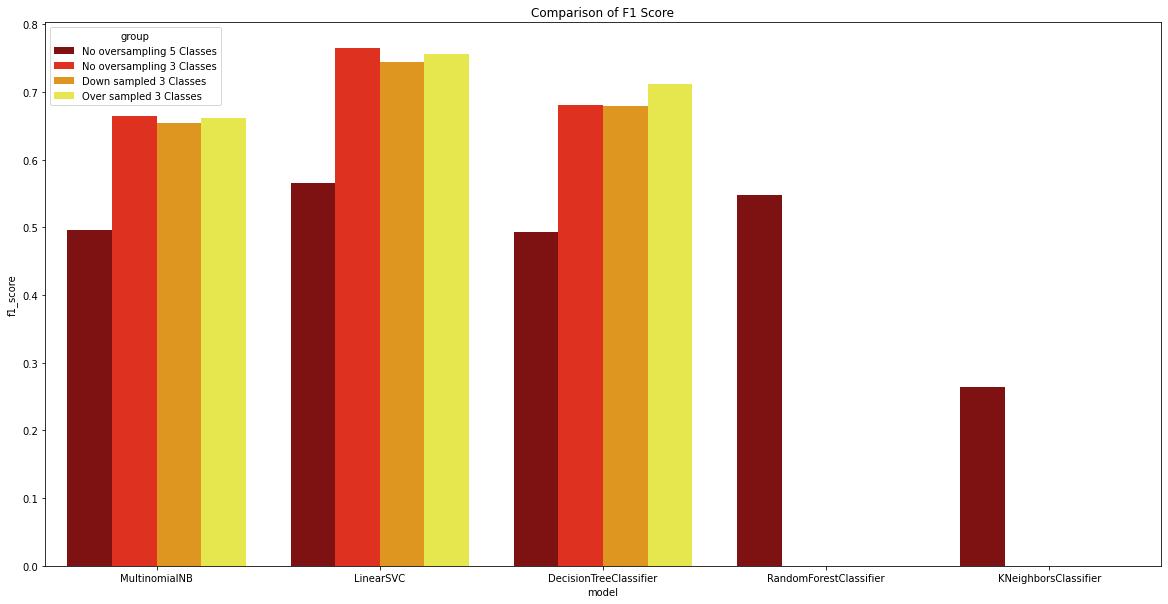

In [ ]:
plot_comparison(model_metrics_df, x='model', y='f1_score', hue='group',
            title='Comparison of F1 Score')

Balanced Weighted Linear Support Vector Machine trained on imbalanced dataset performed better, Bias attached with dataset might be a cause to this. But decision tree classifieer gradually performes better on over sampled dataset. We will now create our final model using balanced weighted LinearSVC

#### Final Model

##### Training

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


svc_pipe = Pipeline([('count', CountVectorizer(max_df=0.7, max_features=7500)),
                    ('model', LinearSVC(multi_class='ovr', class_weight='balanced', max_iter=100000, C=0.1))])

_ = svc_pipe.fit(X_train, y_train)

##### Plotting

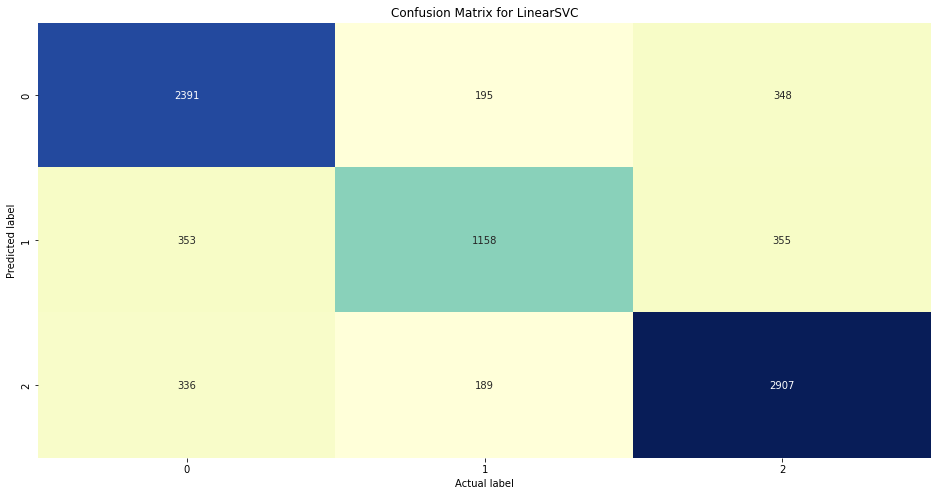

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = svc_pipe.predict(X_test)

plt.figure(figsize=(16, 8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, annot=True, fmt='d', cmap="YlGnBu", cbar=False)

plt.title('Confusion Matrix for LinearSVC')
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
# plt.savefig("confusion_matrix.png")
plt.show()

We will look at the classification report and balanced accuracy explicitly. The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class. 

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print(classification_report(y_test, y_pred))

print("Balanced Accuracy Score is : {}".format(balanced_accuracy_score(y_test, y_pred)))
print("Average Weighted F1 Score is : {}".format(f1_score(y_test, y_pred, average='weighted')))

              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80      3080
     Neutral       0.62      0.75      0.68      1542
    Positive       0.85      0.81      0.83      3610

    accuracy                           0.78      8232
   macro avg       0.76      0.78      0.77      8232
weighted avg       0.79      0.78      0.79      8232

Balanced Accuracy Score is : 0.7775115406131174
Average Weighted F1 Score is : 0.7868602998472509


Let's look at the Reciever Operator Characteristic (ROC) Curve and precision recall curve to get a visual representation of our model's performance. We need to convert the labels for our model using the label_binarize function:

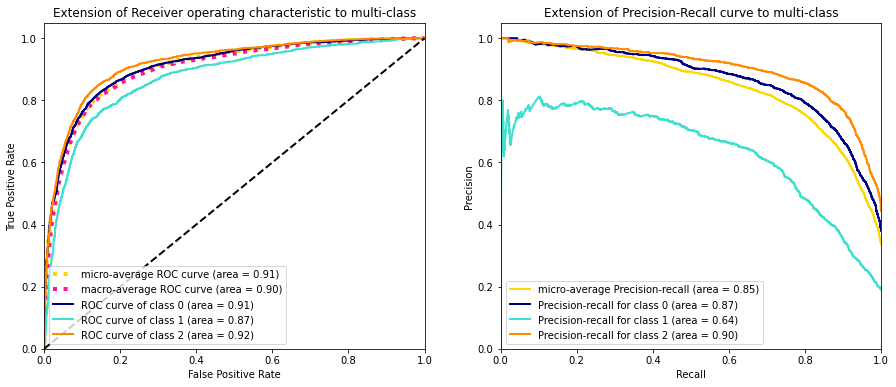

In [ ]:
from sklearn.preprocessing import label_binarize

y_pred_proba = svc_pipe.decision_function(X_test)
n_classes = len(y_test.unique())
classes   = np.sort(y_test.unique())
y_test_lb = label_binarize(y_test, 
                        classes=classes)

plot_roc_pr(y_pred_proba, y_test_lb)

Below, the top 10 words that are most predictive for Positive classes are in blue, while the top 10 words that are most predictive ofor Negative are displayed in red color.

In [ ]:
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

plot_coefficients(
    pipe        = svc_pipe,
    vec_name    = 'count',
    model_name  = 'model',
    label       = label_map["Positive"],
    title      = "Top 15 Influential Words",
    top_n      = 15
)

##### Prediction

In [ ]:
def predict_sentiment(text: list):
    prediction = svc_pipe.predict(text)[0]
    lbl_proba = svc_pipe.decision_function(text)
    if prediction == 'Positive':
        decision_func  = lbl_proba[0][2]
    elif prediction == 'Negative':
        decision_func  = lbl_proba[0][0]
    else:
        decision_func  = lbl_proba[0][1]

    return {
        'sentiment': prediction,
        'confidence': decision_func
    }

In [ ]:
predict_sentiment(["We strongly believe we will get over and start fresh"])

{'confidence': 0.3312890672789367, 'sentiment': 'Positive'}

In [ ]:
predict_sentiment(["Poor people has suffered most during lockdown"])

{'confidence': 0.7043592342139626, 'sentiment': 'Negative'}

In [ ]:
predict_sentiment(["Can we stock some fashionable trendy mask ?"])

{'confidence': 0.23689956100666726, 'sentiment': 'Neutral'}

### **Limitation**

As a multi-class classification problem with imbalanced dataset, we can assume dataset has some bias added within it. Also, we’ve some limited no of vocabulary available in terms of records, as our dataset focused on covid related tweets only Model performance will degrade while analyzing sentiment out of its known context or topic.
On trying some ensemble techniques, the computation cost and time hold us back as we’re trying this experiment on google colab runtime.

### **Scope of Improvement**

In general, we’ve huge scope of improvements. We could add more data to our set to generalize and also can use this from covid related to some healthcare field sentiment analysis easily. Moreover, we should balance the data, balancing could result in significant performance improvement. Also, this could be a tough, but we should check for document misclassification, if not document level, then at least word level, we can choose top importance significant number of words and analyze if the same word looks odd within its specified document label.

We’ve used BOW methods to vectorize the text, we can try tf-idf methods too. Some advanced complex word embedding techniques can also be applied like Glove, doc2vec but those work greatly on larger document corpus, we don’t think with such limited data we’ve those complex methods could perform any better. In terms of modelling, only standard ml algorithms been used in our analysis. Some complex high computation ensemble algorithms like XGBoost, BaggingClassifier, ExtraTreesClassifier can also be tried. We can also move on to try the same analysis with deep learning methods like LSTM etc.


### **Conclusion**

We focused on sentiment analysis for sentence labelling. We described the preprocessing steps, pipeline steps within which text normalization and model cross validation is included, performance has been measured using balanced accuracy, f1 score etc. We used “Stemming” instead of Lemmatization to reduce dimensions, for the same reason we haven’t tried tf-idf or term frequency vectorizer. We concentrated on feeding our model with word count information. Though we can assume bias is present in our dataset, but as we’ve used BOW, we think we haven’t triggered it. Some notable performance increase can be observed when class is reduced from 5 to 3. We assume, in case of binary classification we can further improve this score.

### **Reference**

https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

https://www.techscience.com/cmc/v69n1/42767/html

https://www.kaggle.com/code/venkatkrishnan/nlp-multiclass-onevsrestclassifier/notebook

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

http://michael-harmon.com/blog/NLP1.html
